# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=0)

In [9]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

## Create PyC Subgraph

In [10]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [11]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [12]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [13]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [14]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [15]:
g_th0 = get_thresholded_graph(g_actual, axls, 0)
print(nx.info(g_th0))

Name: 
Type: DiGraph
Number of nodes: 229
Number of edges: 1264
Average in degree:   5.5197
Average out degree:   5.5197


## 2-Cell Motifs

In [22]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th0)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th0)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.8 ms


In [23]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_th0, samples=s, niters=int(1e4), threads=10)

CPU times: user 100 ms, sys: 36 ms, total: 136 ms
Wall time: 2min


connect probability =  0.024208994100972957


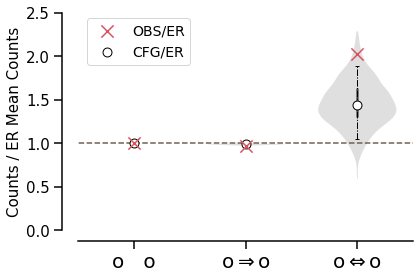

In [51]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2.5), fname="th0/th0_2_violin");

In [25]:
res_two

,obs,er_exp,config_exp,config_std,config_z
actual_edges,NaN,NaN,1264.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,31.0,15.300084,22.314,4.150015,2.093004
neurons,NaN,NaN,229.000,0.000000,NaN
null,24873.0,24857.300084,24864.314,4.150015,2.093004
potential_edges,NaN,NaN,52212.000,0.000000,NaN
uni,1202.0,1233.399831,1219.372,8.300031,-2.093004


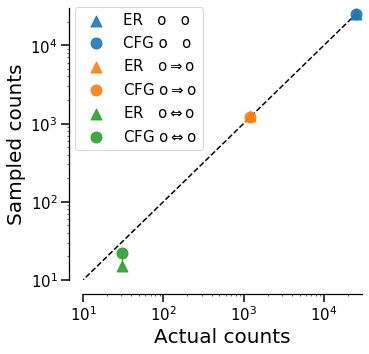

In [26]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="th0/th0_2_scatter")

In [27]:
# p-values
np.minimum((config_two_counts > obs_two_counts).sum(0) / 1000, 
           (config_two_counts < obs_two_counts).sum(0) / 1000)

neurons            0.00
autapses           0.00
actual_edges       0.00
uni                0.02
bi                 0.02
potential_edges    0.00
null               0.02
dtype: float64

## 3-Cell Motifs

In [29]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th0), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th0)
er_three_counts = compute_expected_three_neuron_motifs(g_th0, three_pr)

CPU times: user 1min 38s, sys: 76 ms, total: 1min 38s
Wall time: 1min 39s


In [30]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_th0, samples=s, niters=int(1e4), threads=10)

CPU times: user 564 ms, sys: 84 ms, total: 648 ms
Wall time: 4h 11min 59s


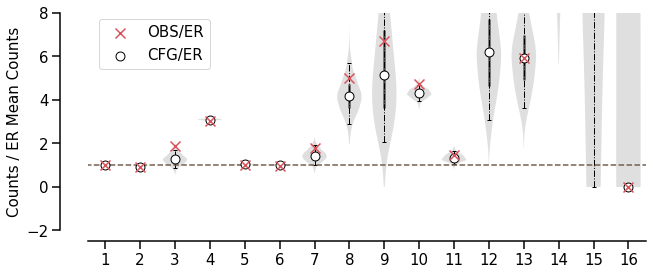

In [31]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 8], fname="th0/th0_3_violin", figsize=(10,4))

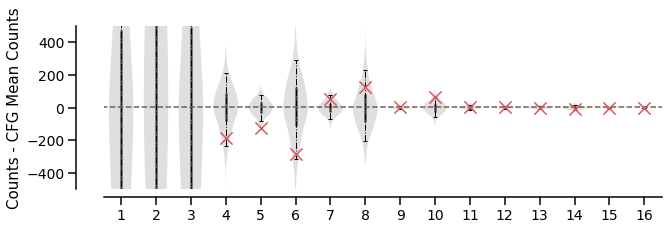

In [32]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="th0/th0_3_violin_diff");

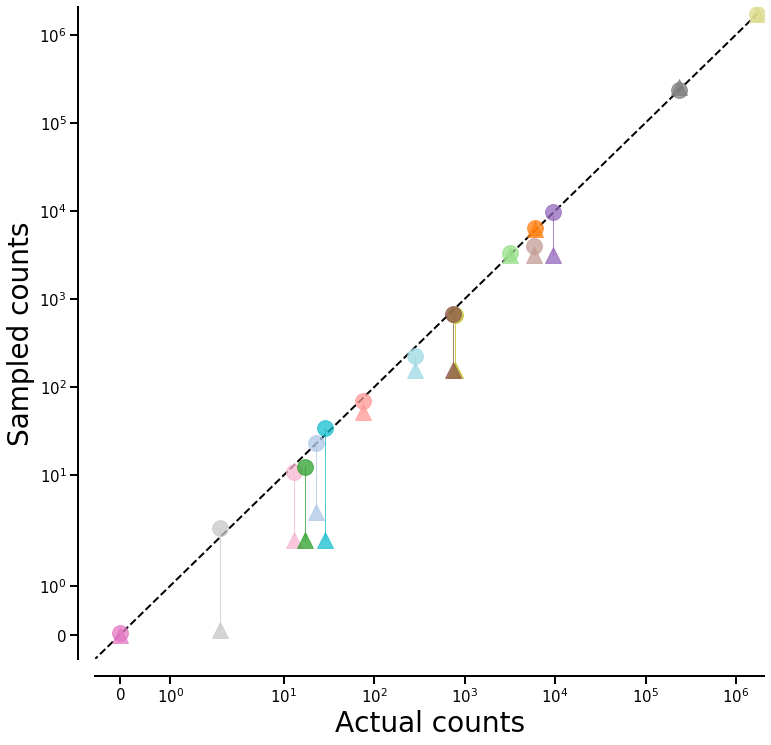

In [33]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="th0/th0_3_scatter")

In [34]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,1717101,1.705241e+06,1715322.472,770.763686,2.307488
2,231625,2.538382e+05,234930.250,1379.731388,-2.395575
3,5875,3.148813e+03,4008.920,782.325540,2.385299
4,9570,3.148813e+03,9755.495,134.099757,-1.383261
5,3166,3.148813e+03,3290.018,47.866595,-2.590909
6,6056,6.297627e+03,6337.870,181.844363,-1.550062
7,280,1.562417e+02,225.942,43.107365,1.254032
8,783,1.562417e+02,657.396,130.310560,0.963882
9,13,1.938147e+00,10.983,5.408323,0.372944
10,738,1.562417e+02,672.405,35.808144,1.831846


In [35]:
# p-values
np.minimum((config_three_counts > obs_three_counts).sum(0) / 1000, 
           (config_three_counts < obs_three_counts).sum(0) / 1000)

1     0.017
2     0.015
3     0.015
4     0.093
5     0.004
6     0.070
7     0.109
8     0.166
9     0.281
10    0.032
11    0.233
12    0.117
13    0.468
14    0.287
15    0.342
16    0.000
dtype: float64

## 3-Cell Motifs (Generalized ER and CFG)

In [36]:
%%time
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th0)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th0, three_pr_GE)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.7 ms


In [37]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_th0, samples=s, niters=int(1e4), threads=10)

CPU times: user 708 ms, sys: 104 ms, total: 812 ms
Wall time: 6h 7min 11s


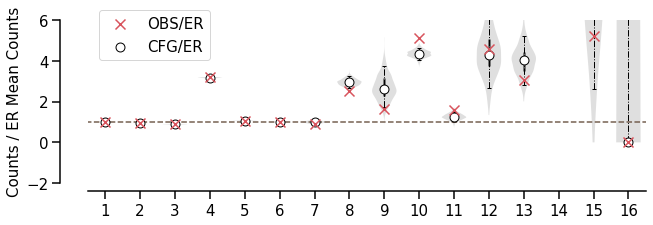

In [38]:
# relative counts in ratio (/ER expected counts)
res_three_GE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                            subtitle='', ylim=[-2, 6], fname="th0/th0_3_violin_GE", figsize=(10,3))

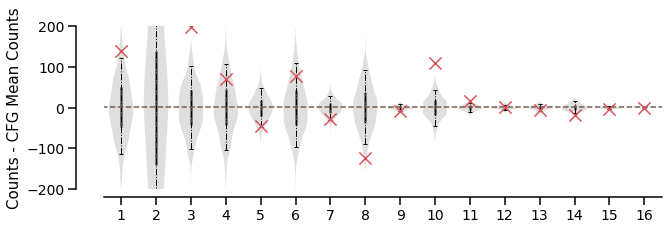

In [39]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                     subtitle='', ylim=[-200, 200], fname="th0/th0_3_violin_diff_GE");

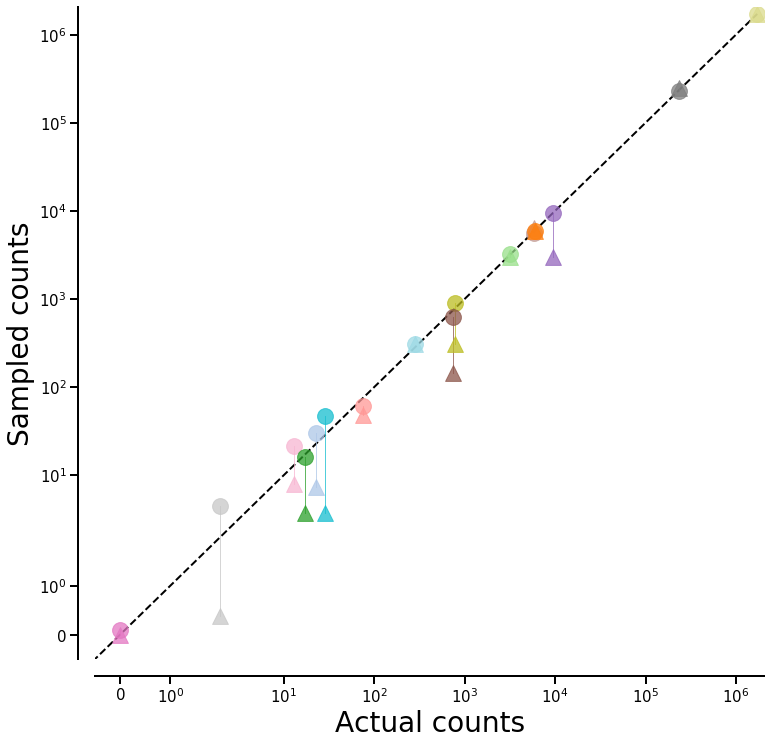

In [40]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                 figsize=(12,12), fname="th0/th0_3_scatter_GE")

In [41]:
res_three_GE

,obs,er_exp,config_exp,config_std,config_z
1,1717101,1.708474e+06,1716961.767,71.790895,1.939424
2,231625,2.476886e+05,232002.305,203.995584,-1.849574
3,5875,6.387975e+03,5677.808,59.283300,3.326266
4,9570,2.992418e+03,9500.674,65.760384,1.054221
5,3166,2.992418e+03,3211.242,29.510783,-1.533067
6,6056,5.984837e+03,5977.998,63.103058,1.236105
7,280,3.087021e+02,307.507,18.015063,-1.526889
8,783,3.087021e+02,906.674,54.885446,-2.253311
9,13,7.961534e+00,21.378,4.925177,-1.701055
10,738,1.446101e+02,628.315,26.760678,4.098738


In [42]:
# p-values
np.minimum((config_three_counts_GE > obs_three_counts).sum(0) / 1000, 
           (config_three_counts_GE < obs_three_counts).sum(0) / 1000)

1     0.026
2     0.033
3     0.000
4     0.151
5     0.054
6     0.117
7     0.064
8     0.009
9     0.021
10    0.000
11    0.020
12    0.368
13    0.094
14    0.012
15    0.061
16    0.000
dtype: float64

## Clustering Coefficient

In [43]:
# clustering coefficient of the observed network
nx.transitivity(g_th0.to_undirected())

0.11787950095457976

In [44]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.04783191280656507

In [45]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.10755110451049052

In [46]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.04723052171914499

In [47]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.10589601287612606

## Generate Plots

connect probability =  0.024208994100972957


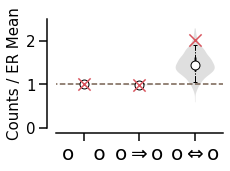

In [101]:
plot_two_neuron_counts_violin_adapt(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2.5), figsize=(3,2), fname="th0/th0_2_violin");

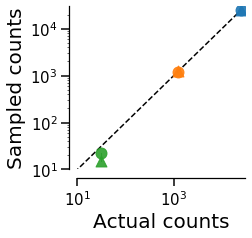

In [87]:
plot_two_neuron_counts_scatter_adapt(obs_two_counts, er_two_counts, config_two_counts, figsize=(3,3), fname="th0/th0_2_scatter");

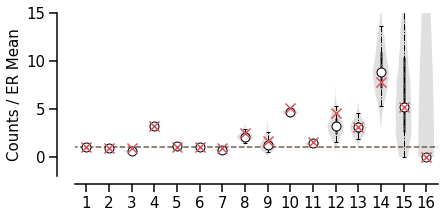

In [102]:
res_three_CGE = plot_three_neuron_counts_violin_adapt(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-2, 15], fname="th0/th0_3_violin_CGE", figsize=(6.5,3))

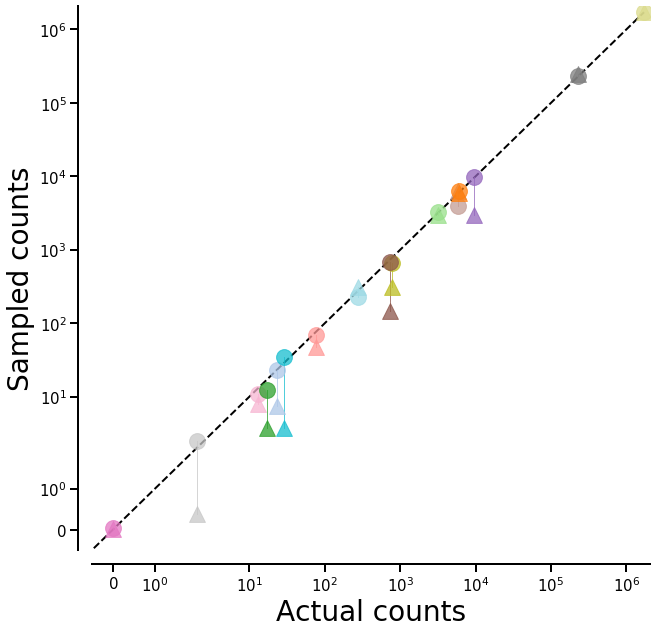

In [106]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(10,10), fname="th0/th0_3_scatter_CGE")